# Based on DLS (МФТИ)

*Thanks to Ilya Zakharkin*

---
### This notebook requires a GPU runtime to run.
### Please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"
---

This notebook is based on [mmdetection colab tutorial](https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb).

## Install MMDetection

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [7]:
!nvidia-smi

Sat Feb  6 12:31:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -r requirements/build.txt
!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 26kB/s 
     |████████████████████████████████| 6.6MB 36.0MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 235kB 8.0MB/s 
     |████████████████████████████████| 194kB 26.3MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.2.6-cp36-cp36m-linux_x86_64.whl size=20234739 sha256=ffaccb77c82cf012f2211dd8b288f38bf253fb80ca468858800a7ec407b8aeca
  Stored in directory: /root/.cache/pip/wheels/40/39/64/7c5ab43621826eb41d31f1df14a8acabf74d879fdf33dc9d79
Successfully built mmcv-full
Cloning into 'mmdetection'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
r

In [8]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True
2.9.0
10.1
GCC 7.5


## Perform inference with a MMDet detector
MMDetection already provides high level APIs to do inference and training.

Let's compare two models: Mask-RCNN (more heavy model) and SSD300 (more lightweight model).

Download the Mask-RCNN weights:

In [21]:
# !mkdir checkpoints
# !wget -c https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
    #   -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2021-02-06 13:07:41--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.60.147
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.60.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/x-www-form-urlencoded]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M  24.2MB/s    in 7.9s    

2021-02-06 13:07:49 (21.5 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]

Download the SSD300 weights:

In [3]:
!mkdir checkpoints
!wget -c http://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20200307-a92d2092.pth \
      -O checkpoints/ssd300_coco_20200307-a92d2092.pth

!wget -c https://github.com/d-li14/mobilenetv2.pytorch/raw/master/pretrained/mobilenetv2_1.0-0c6065bc.pth \
      -O checkpoints/mobilenetv2_1.0-0c6065bc.pth

--2021-02-06 12:21:40--  http://download.openmmlab.com/mmdetection/v2.0/ssd/ssd300_coco/ssd300_coco_20200307-a92d2092.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.78
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137237287 (131M) [application/octet-stream]
Saving to: ‘checkpoints/ssd300_coco_20200307-a92d2092.pth’

checkpoints/ssd300_ 100%[===================>] 130.88M  12.5MB/s    in 10s     

2021-02-06 12:21:52 (12.5 MB/s) - ‘checkpoints/ssd300_coco_20200307-a92d2092.pth’ saved [137237287/137237287]

--2021-02-06 12:21:52--  https://github.com/d-li14/mobilenetv2.pytorch/raw/master/pretrained/mobilenetv2_1.0-0c6065bc.pth
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/d-li14/mobilenetv2.pyt

In [ ]:
!ls checkpoints

mobilenetv2_1.0-0c6065bc.pth  ssd300_coco_20200307-a92d2092.pth


We will use internal API methods for initialization, inference and visualization ofr model predictions:

Mask-RCNN:

In [58]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config = 'configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
# initialize the detector
model = init_detector(config, checkpoint)

In [59]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

/content/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


In [ ]:
print(result)

/content/mmdetection/mmdet/apis/inference.py:186: UserWarning: "block" will be deprecated in v2.9.0,Please use "wait_time"
  warnings.warn('"block" will be deprecated in v2.9.0,'
/content/mmdetection/mmdet/core/visualization/image.py:76: UserWarning: "font_scale" will be deprecated in v2.9.0,Please use "font_size"
  warnings.warn('"font_scale" will be deprecated in v2.9.0,'


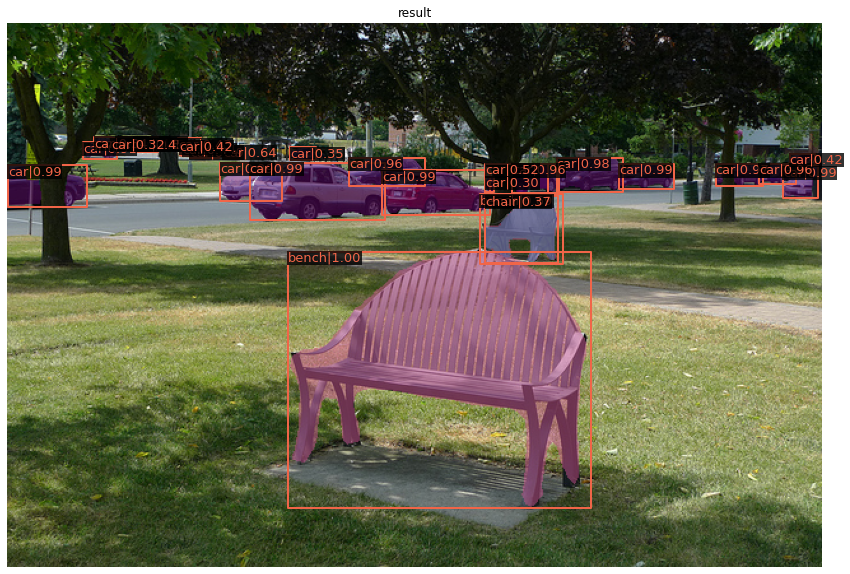

In [ ]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

SSD300:

In [ ]:
config = 'configs/ssd/ssd300_coco.py'
# checkpoint = 'checkpoints/ssd300_coco_20200307-a92d2092.pth'
model = init_detector(config, checkpoint, device='cpu')
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

### mobilenetv2-ssd register begin 
(u need to run this hidden cell for mmdetection to see the new backbone)

In [ ]:
import torch
import torch.nn as nn
from mmcv.cnn import constant_init, kaiming_init, normal_init
from mmdet.models.builder import BACKBONES


def conv_bn(inp, oup, stride, groups=1, act_fn=nn.ReLU):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False, groups=groups),
        nn.BatchNorm2d(oup),
        act_fn(inplace=True)
    )
def conv_1x1_bn(inp, oup, groups=1, act_fn=nn.ReLU):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False, groups=groups),
        nn.BatchNorm2d(oup),
        act_fn(inplace=True)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, ssd_output=False,
                 activation=nn.ReLU):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        inp = int(inp)
        oup = int(oup)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1,
                          groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                activation(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = [
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                activation(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1,
                          groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                activation(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            ]
        self.ssd_output = ssd_output
        if self.ssd_output:
            self.output_conv = conv_1x1_bn(hidden_dim, hidden_dim, 1,
                                           activation)
            self.conv1 = nn.Sequential(*self.conv[0:3])
            self.conv2 = nn.Sequential(*self.conv[3:])
        else:
            self.conv = nn.Sequential(*self.conv)

    def compute_conv(self, x):
        if not self.ssd_output:
            return self.conv(x)

        expanded_x = self.output_conv(self.conv1(x))
        return (expanded_x, self.conv2(expanded_x))

    def forward(self, x):
        if self.use_res_connect:
            if self.ssd_output:
                expanded, conv = self.compute_conv(x)
                return (expanded, x + conv)
            return x + self.compute_conv(x)
        else:
            return self.compute_conv(x)


@BACKBONES.register_module()
class SSDMobilenetV2(nn.Module):
    def __init__(self, input_size, width_mult=1.0,
                 activation_type='relu',
                 single_scale=False):
        super(SSDMobilenetV2, self).__init__()
        self.input_size = input_size
        self.single_scale = single_scale
        self.width_mult = width_mult
        block = InvertedResidual
        input_channel = 32
        last_channel = 320
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]
        if self.single_scale:
            interverted_residual_setting[-2] = [6, 160, 3, 1]
            interverted_residual_setting[-1] = [4, 480, 1, 1]

        assert activation_type in ['relu', 'relu6']
        if activation_type in 'relu':
            self.activation_class = nn.ReLU
        else:
            self.activation_class = nn.ReLU6

        # building the first layer
        input_channel = int(input_channel * self.width_mult)
        if self.width_mult > 1.0:
            self.last_channel = int(last_channel * self.width_mult)
        else:
            self.last_channel = last_channel
        self.bn_first = nn.BatchNorm2d(3)
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = c * self.width_mult
            for i in range(n):
                ssd_output = False
                if i == 0 and c == 160 and s == 2 and not self.single_scale:
                    ssd_output = True
                if i == 0:
                    self.features.append(block(input_channel, output_channel,
                                               s, t, ssd_output,
                                               self.activation_class))
                else:
                    self.features.append(block(input_channel, output_channel,
                                               1, t, ssd_output,
                                               self.activation_class))
                input_channel = output_channel
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building last several layers
        self.extra_convs = []
        if not self.single_scale:
            self.extra_convs.append(conv_1x1_bn(last_channel, 1280,
                                                act_fn=self.activation_class))
            self.extra_convs.append(conv_1x1_bn(1280, 256,
                                                act_fn=self.activation_class))
            self.extra_convs.append(conv_bn(256, 256, 2, groups=256,
                                            act_fn=self.activation_class))
            self.extra_convs.append(conv_1x1_bn(256, 512, groups=1,
                                                act_fn=self.activation_class))
            self.extra_convs.append(conv_1x1_bn(512, 128,
                                                act_fn=self.activation_class))
            self.extra_convs.append(conv_bn(128, 128, 2, groups=128,
                                            act_fn=self.activation_class))
            self.extra_convs.append(conv_1x1_bn(128, 256,
                                                act_fn=self.activation_class))
            self.extra_convs.append(conv_1x1_bn(256, 128,
                                                act_fn=self.activation_class))
            self.extra_convs.append(conv_bn(128, 128, 2, groups=128,
                                            act_fn=self.activation_class))
            self.extra_convs.append(conv_1x1_bn(128, 256,
                                                act_fn=self.activation_class))
            self.extra_convs.append(conv_1x1_bn(256, 64,
                                                act_fn=self.activation_class))
            self.extra_convs.append(conv_bn(64, 64, 2, groups=64,
                                            act_fn=self.activation_class))
            self.extra_convs.append(conv_1x1_bn(64, 128,
                                                act_fn=self.activation_class))
            self.extra_convs = nn.Sequential(*self.extra_convs)

    @property
    def activation_fun(self):
        return self.activation_class

    def init_weights(self, pretrained=None):
        if isinstance(pretrained, str):
            state_dict = torch.load(pretrained)
            if 'state_dict' in state_dict:
                state_dict = state_dict['state_dict']

            if self.width_mult < 1.0:
                patched_dict = {}
                for k, v in state_dict.items():
                    if 'backbone.' in k:
                        k = k[len('backbone.'):]
                    if 'features.17.conv' in k and self.single_scale:
                        continue
                    if 'conv' in k:  # process convs in inverted residuals
                        if len(v.shape) == 1:
                            v = v[:int(v.shape[0] * self.width_mult)]
                        elif len(v.shape) == 4 and v.shape[1] == 1:
                            assert v.shape[2] == v.shape[3] and v.shape[2] == 3
                            v = v[:int(v.shape[0] * self.width_mult), ]
                        elif len(v.shape) == 4 and v.shape[2] == 1:
                            assert v.shape[2] == v.shape[3] and v.shape[2] == 1
                            v = v[:int(v.shape[0] * self.width_mult),
                                :int(v.shape[1] * self.width_mult), ]
                    elif 'features.0.' in k:  # process the first conv
                        if len(v.shape):
                            v = v[:int(v.shape[0] * self.width_mult), ]

                    patched_dict[k] = v

                self.load_state_dict(patched_dict, strict=False)
            elif self.width_mult == 1.0:
                patched_dict = {}
                if self.single_scale:
                    for k, v in state_dict.items():
                        if 'features.17.conv' in k:
                            continue
                        patched_dict[k] = v
                else:
                    patched_dict = state_dict

                self.load_state_dict(patched_dict, strict=False)
            else:
                print('Warning: loading of pre-trained weights is not \
                               supported for MobileNetV2 with width_mult > 1')
        elif pretrained is None:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    kaiming_init(m)
                elif isinstance(m, nn.BatchNorm2d):
                    constant_init(m, 1)
                elif isinstance(m, nn.Linear):
                    normal_init(m, std=0.01)
        else:
            raise TypeError('pretrained must be a str or None')

    def forward(self, x):
        outs = []
        x = self.bn_first(x)
        for i, block in enumerate(self.features):
            x = block(x)
            if isinstance(x, tuple):
                outs.append(x[0])
                x = x[1]

        for i, conv in enumerate(self.extra_convs):
            x = conv(x)
            if i % 3 == 0:
                outs.append(x)

        if self.single_scale:
            outs.append(x)

        return tuple(outs)

### ssdmobilenetv2 register end

In [ ]:
config = 'configs/ssd/ssd300_coco.py'
checkpoint = 'checkpoints/ssd300_coco_20200307-a92d2092.pth'
model = init_detector(config, checkpoint)
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

In [ ]:
!ls -la checkpoints

total 307736
drwxr-xr-x  2 root root      4096 Jan 31 09:50 .
drwxr-xr-x 16 root root      4096 Jan 31 09:50 ..
-rw-r--r--  1 root root 177867103 May 18  2020 mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
-rw-r--r--  1 root root 137237287 Aug 27 17:44 ssd300_coco_20200307-a92d2092.pth


**Insight**: Mask-RCNN weights 178Mb, and SSD weights 137Mb, and it logically corresponds to their quality: SSD sees less objects on the scenes, therefore it has more False Negatives.

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. reorganize the dataset into COCO format.
  2. reorganize the dataset into a middle format.
  3. implement a new dataset.

Usually we recommend to use the first two methods which are usually easier than the third.

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
# !unzip -q /content/drive/MyDrive/Работка/CompTech2021/bdd100k/bdd100k_images.zip -d /content/
!rm -rf /content/bdd100k/

In [37]:
%%writefile prep_script.sh

unzip -q /content/drive/MyDrive/Работка/CompTech2021/bdd100k/bdd100k_images.zip -d /content/
mkdir /content/ann_files
cp /content/drive/MyDrive/Работка/CompTech2021/bdd100k/labels_train.json -d /content/ann_files/
cp /content/drive/MyDrive/Работка/CompTech2021/bdd100k/labels_val.json -d /content/ann_files/
rm -rf /content/__MACOSX

Writing prep_script.sh


In [38]:
%%shell
bash prep_script.sh

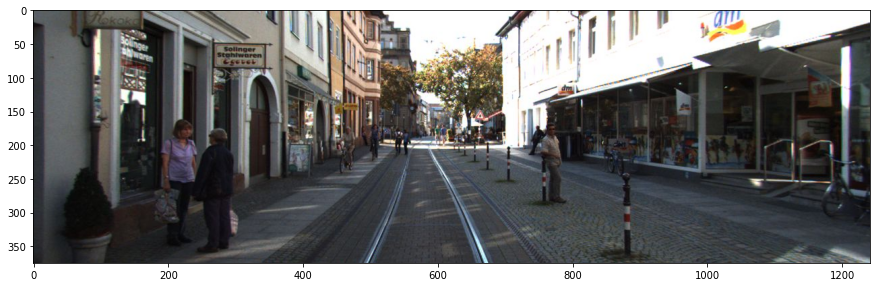

In [ ]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('kitti_tiny/training/image_2/000073.jpeg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

### костылим coco датасет под наши классы

In [39]:
import itertools
import logging
import os.path as osp
import tempfile
from collections import OrderedDict

import mmcv
import numpy as np
from mmcv.utils import print_log
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from terminaltables import AsciiTable

from mmdet.core import eval_recalls
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

try:
    import pycocotools
    if not hasattr(pycocotools, '__sphinx_mock__'):  # for doc generation
        assert pycocotools.__version__ >= '12.0.2'
except AssertionError:
    raise AssertionError('Incompatible version of pycocotools is installed. '
                         'Run pip uninstall pycocotools first. Then run pip '
                         'install mmpycocotools to install open-mmlab forked '
                         'pycocotools.')


@DATASETS.register_module()
class MyCocoDataset(CustomDataset):

    CLASSES = ('сar', 'pedestrian', 'traffic sign')

    def load_annotations(self, ann_file):
        """Load annotation from COCO style annotation file.

        Args:
            ann_file (str): Path of annotation file.

        Returns:
            list[dict]: Annotation info from COCO api.
        """

        self.coco = COCO(ann_file)
        self.cat_ids = self.coco.get_cat_ids(cat_names=self.CLASSES)
        self.cat2label = {cat_id: i for i, cat_id in enumerate(self.cat_ids)}
        self.img_ids = self.coco.get_img_ids()
        data_infos = []
        for i in self.img_ids:
            info = self.coco.load_imgs([i])[0]
            info['filename'] = info['file_name']
            data_infos.append(info)
        return data_infos

    def get_ann_info(self, idx):
        """Get COCO annotation by index.

        Args:
            idx (int): Index of data.

        Returns:
            dict: Annotation info of specified index.
        """

        img_id = self.data_infos[idx]['id']
        ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
        ann_info = self.coco.load_anns(ann_ids)
        return self._parse_ann_info(self.data_infos[idx], ann_info)

    def get_cat_ids(self, idx):
        """Get COCO category ids by index.

        Args:
            idx (int): Index of data.

        Returns:
            list[int]: All categories in the image of specified index.
        """

        img_id = self.data_infos[idx]['id']
        ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
        ann_info = self.coco.load_anns(ann_ids)
        return [ann['category_id'] for ann in ann_info]

    def _filter_imgs(self, min_size=32):
        """Filter images too small or without ground truths."""
        valid_inds = []
        # obtain images that contain annotation
        ids_with_ann = set(_['image_id'] for _ in self.coco.anns.values())
        # obtain images that contain annotations of the required categories
        ids_in_cat = set()
        for i, class_id in enumerate(self.cat_ids):
            ids_in_cat |= set(self.coco.cat_img_map[class_id])
        # merge the image id sets of the two conditions and use the merged set
        # to filter out images if self.filter_empty_gt=True
        ids_in_cat &= ids_with_ann

        valid_img_ids = []
        for i, img_info in enumerate(self.data_infos):
            img_id = self.img_ids[i]
            if self.filter_empty_gt and img_id not in ids_in_cat:
                continue
            if min(img_info['width'], img_info['height']) >= min_size:
                valid_inds.append(i)
                valid_img_ids.append(img_id)
        self.img_ids = valid_img_ids
        return valid_inds

    def _parse_ann_info(self, img_info, ann_info):
        """Parse bbox and mask annotation.

        Args:
            ann_info (list[dict]): Annotation info of an image.
            with_mask (bool): Whether to parse mask annotations.

        Returns:
            dict: A dict containing the following keys: bboxes, bboxes_ignore,\
                labels, masks, seg_map. "masks" are raw annotations and not \
                decoded into binary masks.
        """
        gt_bboxes = []
        gt_labels = []
        gt_bboxes_ignore = []
        gt_masks_ann = []
        for i, ann in enumerate(ann_info):
            if ann.get('ignore', False):
                continue
            x1, y1, w, h = ann['bbox']
            inter_w = max(0, min(x1 + w, img_info['width']) - max(x1, 0))
            inter_h = max(0, min(y1 + h, img_info['height']) - max(y1, 0))
            if inter_w * inter_h == 0:
                continue
            if ann['area'] <= 0 or w < 1 or h < 1:
                continue
            if ann['category_id'] not in self.cat_ids:
                continue
            bbox = [x1, y1, x1 + w, y1 + h]
            if ann.get('iscrowd', False):
                gt_bboxes_ignore.append(bbox)
            else:
                gt_bboxes.append(bbox)
                gt_labels.append(self.cat2label[ann['category_id']])
                gt_masks_ann.append(ann.get('segmentation', None))

        if gt_bboxes:
            gt_bboxes = np.array(gt_bboxes, dtype=np.float32)
            gt_labels = np.array(gt_labels, dtype=np.int64)
        else:
            gt_bboxes = np.zeros((0, 4), dtype=np.float32)
            gt_labels = np.array([], dtype=np.int64)

        if gt_bboxes_ignore:
            gt_bboxes_ignore = np.array(gt_bboxes_ignore, dtype=np.float32)
        else:
            gt_bboxes_ignore = np.zeros((0, 4), dtype=np.float32)

        seg_map = img_info['filename'].replace('jpg', 'png')

        ann = dict(
            bboxes=gt_bboxes,
            labels=gt_labels,
            bboxes_ignore=gt_bboxes_ignore,
            masks=gt_masks_ann,
            seg_map=seg_map)

        return ann

    def xyxy2xywh(self, bbox):
        """Convert ``xyxy`` style bounding boxes to ``xywh`` style for COCO
        evaluation.

        Args:
            bbox (numpy.ndarray): The bounding boxes, shape (4, ), in
                ``xyxy`` order.

        Returns:
            list[float]: The converted bounding boxes, in ``xywh`` order.
        """

        _bbox = bbox.tolist()
        return [
            _bbox[0],
            _bbox[1],
            _bbox[2] - _bbox[0],
            _bbox[3] - _bbox[1],
        ]

    def _proposal2json(self, results):
        """Convert proposal results to COCO json style."""
        json_results = []
        for idx in range(len(self)):
            img_id = self.img_ids[idx]
            bboxes = results[idx]
            for i in range(bboxes.shape[0]):
                data = dict()
                data['image_id'] = img_id
                data['bbox'] = self.xyxy2xywh(bboxes[i])
                data['score'] = float(bboxes[i][4])
                data['category_id'] = 1
                json_results.append(data)
        return json_results

    def _det2json(self, results):
        """Convert detection results to COCO json style."""
        json_results = []
        for idx in range(len(self)):
            img_id = self.img_ids[idx]
            result = results[idx]
            for label in range(len(result)):
                bboxes = result[label]
                for i in range(bboxes.shape[0]):
                    data = dict()
                    data['image_id'] = img_id
                    data['bbox'] = self.xyxy2xywh(bboxes[i])
                    data['score'] = float(bboxes[i][4])
                    data['category_id'] = self.cat_ids[label]
                    json_results.append(data)
        return json_results

    def _segm2json(self, results):
        """Convert instance segmentation results to COCO json style."""
        bbox_json_results = []
        segm_json_results = []
        for idx in range(len(self)):
            img_id = self.img_ids[idx]
            det, seg = results[idx]
            for label in range(len(det)):
                # bbox results
                bboxes = det[label]
                for i in range(bboxes.shape[0]):
                    data = dict()
                    data['image_id'] = img_id
                    data['bbox'] = self.xyxy2xywh(bboxes[i])
                    data['score'] = float(bboxes[i][4])
                    data['category_id'] = self.cat_ids[label]
                    bbox_json_results.append(data)

                # segm results
                # some detectors use different scores for bbox and mask
                if isinstance(seg, tuple):
                    segms = seg[0][label]
                    mask_score = seg[1][label]
                else:
                    segms = seg[label]
                    mask_score = [bbox[4] for bbox in bboxes]
                for i in range(bboxes.shape[0]):
                    data = dict()
                    data['image_id'] = img_id
                    data['bbox'] = self.xyxy2xywh(bboxes[i])
                    data['score'] = float(mask_score[i])
                    data['category_id'] = self.cat_ids[label]
                    if isinstance(segms[i]['counts'], bytes):
                        segms[i]['counts'] = segms[i]['counts'].decode()
                    data['segmentation'] = segms[i]
                    segm_json_results.append(data)
        return bbox_json_results, segm_json_results

    def results2json(self, results, outfile_prefix):
        """Dump the detection results to a COCO style json file.

        There are 3 types of results: proposals, bbox predictions, mask
        predictions, and they have different data types. This method will
        automatically recognize the type, and dump them to json files.

        Args:
            results (list[list | tuple | ndarray]): Testing results of the
                dataset.
            outfile_prefix (str): The filename prefix of the json files. If the
                prefix is "somepath/xxx", the json files will be named
                "somepath/xxx.bbox.json", "somepath/xxx.segm.json",
                "somepath/xxx.proposal.json".

        Returns:
            dict[str: str]: Possible keys are "bbox", "segm", "proposal", and \
                values are corresponding filenames.
        """
        result_files = dict()
        if isinstance(results[0], list):
            json_results = self._det2json(results)
            result_files['bbox'] = f'{outfile_prefix}.bbox.json'
            result_files['proposal'] = f'{outfile_prefix}.bbox.json'
            mmcv.dump(json_results, result_files['bbox'])
        elif isinstance(results[0], tuple):
            json_results = self._segm2json(results)
            result_files['bbox'] = f'{outfile_prefix}.bbox.json'
            result_files['proposal'] = f'{outfile_prefix}.bbox.json'
            result_files['segm'] = f'{outfile_prefix}.segm.json'
            mmcv.dump(json_results[0], result_files['bbox'])
            mmcv.dump(json_results[1], result_files['segm'])
        elif isinstance(results[0], np.ndarray):
            json_results = self._proposal2json(results)
            result_files['proposal'] = f'{outfile_prefix}.proposal.json'
            mmcv.dump(json_results, result_files['proposal'])
        else:
            raise TypeError('invalid type of results')
        return result_files

    def fast_eval_recall(self, results, proposal_nums, iou_thrs, logger=None):
        gt_bboxes = []
        for i in range(len(self.img_ids)):
            ann_ids = self.coco.get_ann_ids(img_ids=self.img_ids[i])
            ann_info = self.coco.load_anns(ann_ids)
            if len(ann_info) == 0:
                gt_bboxes.append(np.zeros((0, 4)))
                continue
            bboxes = []
            for ann in ann_info:
                if ann.get('ignore', False) or ann['iscrowd']:
                    continue
                x1, y1, w, h = ann['bbox']
                bboxes.append([x1, y1, x1 + w, y1 + h])
            bboxes = np.array(bboxes, dtype=np.float32)
            if bboxes.shape[0] == 0:
                bboxes = np.zeros((0, 4))
            gt_bboxes.append(bboxes)

        recalls = eval_recalls(
            gt_bboxes, results, proposal_nums, iou_thrs, logger=logger)
        ar = recalls.mean(axis=1)
        return ar

    def format_results(self, results, jsonfile_prefix=None, **kwargs):
        """Format the results to json (standard format for COCO evaluation).

        Args:
            results (list[tuple | numpy.ndarray]): Testing results of the
                dataset.
            jsonfile_prefix (str | None): The prefix of json files. It includes
                the file path and the prefix of filename, e.g., "a/b/prefix".
                If not specified, a temp file will be created. Default: None.

        Returns:
            tuple: (result_files, tmp_dir), result_files is a dict containing \
                the json filepaths, tmp_dir is the temporal directory created \
                for saving json files when jsonfile_prefix is not specified.
        """
        assert isinstance(results, list), 'results must be a list'
        assert len(results) == len(self), (
            'The length of results is not equal to the dataset len: {} != {}'.
            format(len(results), len(self)))

        if jsonfile_prefix is None:
            tmp_dir = tempfile.TemporaryDirectory()
            jsonfile_prefix = osp.join(tmp_dir.name, 'results')
        else:
            tmp_dir = None
        result_files = self.results2json(results, jsonfile_prefix)
        return result_files, tmp_dir

    def evaluate(self,
                 results,
                 metric='bbox',
                 logger=None,
                 jsonfile_prefix=None,
                 classwise=False,
                 proposal_nums=(100, 300, 1000),
                 iou_thrs=None,
                 metric_items=None):
        """Evaluation in COCO protocol.

        Args:
            results (list[list | tuple]): Testing results of the dataset.
            metric (str | list[str]): Metrics to be evaluated. Options are
                'bbox', 'segm', 'proposal', 'proposal_fast'.
            logger (logging.Logger | str | None): Logger used for printing
                related information during evaluation. Default: None.
            jsonfile_prefix (str | None): The prefix of json files. It includes
                the file path and the prefix of filename, e.g., "a/b/prefix".
                If not specified, a temp file will be created. Default: None.
            classwise (bool): Whether to evaluating the AP for each class.
            proposal_nums (Sequence[int]): Proposal number used for evaluating
                recalls, such as recall@100, recall@1000.
                Default: (100, 300, 1000).
            iou_thrs (Sequence[float], optional): IoU threshold used for
                evaluating recalls/mAPs. If set to a list, the average of all
                IoUs will also be computed. If not specified, [0.50, 0.55,
                0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95] will be used.
                Default: None.
            metric_items (list[str] | str, optional): Metric items that will
                be returned. If not specified, ``['AR@100', 'AR@300',
                'AR@1000', 'AR_s@1000', 'AR_m@1000', 'AR_l@1000' ]`` will be
                used when ``metric=='proposal'``, ``['mAP', 'mAP_50', 'mAP_75',
                'mAP_s', 'mAP_m', 'mAP_l']`` will be used when
                ``metric=='bbox' or metric=='segm'``.

        Returns:
            dict[str, float]: COCO style evaluation metric.
        """

        metrics = metric if isinstance(metric, list) else [metric]
        allowed_metrics = ['bbox', 'segm', 'proposal', 'proposal_fast']
        for metric in metrics:
            if metric not in allowed_metrics:
                raise KeyError(f'metric {metric} is not supported')
        if iou_thrs is None:
            iou_thrs = np.linspace(
                .5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
        if metric_items is not None:
            if not isinstance(metric_items, list):
                metric_items = [metric_items]

        result_files, tmp_dir = self.format_results(results, jsonfile_prefix)

        eval_results = OrderedDict()
        cocoGt = self.coco
        for metric in metrics:
            msg = f'Evaluating {metric}...'
            if logger is None:
                msg = '\n' + msg
            print_log(msg, logger=logger)

            if metric == 'proposal_fast':
                ar = self.fast_eval_recall(
                    results, proposal_nums, iou_thrs, logger='silent')
                log_msg = []
                for i, num in enumerate(proposal_nums):
                    eval_results[f'AR@{num}'] = ar[i]
                    log_msg.append(f'\nAR@{num}\t{ar[i]:.4f}')
                log_msg = ''.join(log_msg)
                print_log(log_msg, logger=logger)
                continue

            if metric not in result_files:
                raise KeyError(f'{metric} is not in results')
            try:
                cocoDt = cocoGt.loadRes(result_files[metric])
            except IndexError:
                print_log(
                    'The testing results of the whole dataset is empty.',
                    logger=logger,
                    level=logging.ERROR)
                break

            iou_type = 'bbox' if metric == 'proposal' else metric
            cocoEval = COCOeval(cocoGt, cocoDt, iou_type)
            cocoEval.params.catIds = self.cat_ids
            cocoEval.params.imgIds = self.img_ids
            cocoEval.params.maxDets = list(proposal_nums)
            cocoEval.params.iouThrs = iou_thrs
            # mapping of cocoEval.stats
            coco_metric_names = {
                'mAP': 0,
                'mAP_50': 1,
                'mAP_75': 2,
                'mAP_s': 3,
                'mAP_m': 4,
                'mAP_l': 5,
                'AR@100': 6,
                'AR@300': 7,
                'AR@1000': 8,
                'AR_s@1000': 9,
                'AR_m@1000': 10,
                'AR_l@1000': 11
            }
            if metric_items is not None:
                for metric_item in metric_items:
                    if metric_item not in coco_metric_names:
                        raise KeyError(
                            f'metric item {metric_item} is not supported')

            if metric == 'proposal':
                cocoEval.params.useCats = 0
                cocoEval.evaluate()
                cocoEval.accumulate()
                cocoEval.summarize()
                if metric_items is None:
                    metric_items = [
                        'AR@100', 'AR@300', 'AR@1000', 'AR_s@1000',
                        'AR_m@1000', 'AR_l@1000'
                    ]

                for item in metric_items:
                    val = float(
                        f'{cocoEval.stats[coco_metric_names[item]]:.3f}')
                    eval_results[item] = val
            else:
                cocoEval.evaluate()
                cocoEval.accumulate()
                cocoEval.summarize()
                if classwise:  # Compute per-category AP
                    # Compute per-category AP
                    # from https://github.com/facebookresearch/detectron2/
                    precisions = cocoEval.eval['precision']
                    # precision: (iou, recall, cls, area range, max dets)
                    assert len(self.cat_ids) == precisions.shape[2]

                    results_per_category = []
                    for idx, catId in enumerate(self.cat_ids):
                        # area range index 0: all area ranges
                        # max dets index -1: typically 100 per image
                        nm = self.coco.loadCats(catId)[0]
                        precision = precisions[:, :, idx, 0, -1]
                        precision = precision[precision > -1]
                        if precision.size:
                            ap = np.mean(precision)
                        else:
                            ap = float('nan')
                        results_per_category.append(
                            (f'{nm["name"]}', f'{float(ap):0.3f}'))

                    num_columns = min(6, len(results_per_category) * 2)
                    results_flatten = list(
                        itertools.chain(*results_per_category))
                    headers = ['category', 'AP'] * (num_columns // 2)
                    results_2d = itertools.zip_longest(*[
                        results_flatten[i::num_columns]
                        for i in range(num_columns)
                    ])
                    table_data = [headers]
                    table_data += [result for result in results_2d]
                    table = AsciiTable(table_data)
                    print_log('\n' + table.table, logger=logger)

                if metric_items is None:
                    metric_items = [
                        'mAP', 'mAP_50', 'mAP_75', 'mAP_s', 'mAP_m', 'mAP_l'
                    ]

                for metric_item in metric_items:
                    key = f'{metric}_{metric_item}'
                    val = float(
                        f'{cocoEval.stats[coco_metric_names[metric_item]]:.3f}'
                    )
                    eval_results[key] = val
                ap = cocoEval.stats[:6]
                eval_results[f'{metric}_mAP_copypaste'] = (
                    f'{ap[0]:.3f} {ap[1]:.3f} {ap[2]:.3f} {ap[3]:.3f} '
                    f'{ap[4]:.3f} {ap[5]:.3f}')
        if tmp_dir is not None:
            tmp_dir.cleanup()
        return eval_results


### конец ужаса

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [89]:
from mmcv import Config
cfg = Config.fromfile('./configs/ssd/ssd300_coco.py')

In [90]:
cfg["data"]

{'samples_per_gpu': 8,
 'test': {'ann_file': 'data/coco/annotations/instances_val2017.json',
  'img_prefix': 'data/coco/val2017/',
  'pipeline': [{'type': 'LoadImageFromFile'},
   {'flip': False,
    'img_scale': (300, 300),
    'transforms': [{'keep_ratio': False, 'type': 'Resize'},
     {'mean': [123.675, 116.28, 103.53],
      'std': [1, 1, 1],
      'to_rgb': True,
      'type': 'Normalize'},
     {'keys': ['img'], 'type': 'ImageToTensor'},
     {'keys': ['img'], 'type': 'Collect'}],
    'type': 'MultiScaleFlipAug'}],
  'type': 'CocoDataset'},
 'train': {'dataset': {'ann_file': 'data/coco/annotations/instances_train2017.json',
   'img_prefix': 'data/coco/train2017/',
   'pipeline': [{'to_float32': True, 'type': 'LoadImageFromFile'},
    {'type': 'LoadAnnotations', 'with_bbox': True},
    {'brightness_delta': 32,
     'contrast_range': (0.5, 1.5),
     'hue_delta': 18,
     'saturation_range': (0.5, 1.5),
     'type': 'PhotoMetricDistortion'},
    {'mean': [123.675, 116.28, 103.53],

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.


> - [SSD training issue 1](https://github.com/open-mmlab/mmdetection/issues/1203)
- [SSD training issue 2](https://github.com/open-mmlab/mmdetection/issues/2448)

In [91]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'MyCocoDataset'
cfg.classes = ('pedestrian', 'сar', 'traffic sign')
cfg.data_root = '/content/bdd100k/'

cfg.data.test.type = 'MyCocoDataset'
cfg.data.test.classes = cfg.classes
cfg.data.test.data_root = '/content/bdd100k/'
cfg.data.test.ann_file = '/content/ann_files/labels_val.json'
cfg.data.test.img_prefix = 'images/100k/val/'

cfg.data.train.dataset.type = 'MyCocoDataset'
cfg.data.train.classes = cfg.classes
cfg.data.train.dataset.data_root = '/content/bdd100k/'
cfg.data.train.dataset.ann_file = '/content/ann_files/labels_train.json'
cfg.data.train.dataset.img_prefix = 'images/100k/train/'

cfg.data.samples_per_gpu = 64
cfg.data.workers_per_gpu = 4

cfg.data.val.type = 'MyCocoDataset'
cfg.data.val.classes = cfg.classes
cfg.data.val.data_root = '/content/bdd100k/'
cfg.data.val.ann_file = '/content/ann_files/labels_val.json'
cfg.data.val.img_prefix = 'images/100k/val/'

cfg.model.bbox_head.num_classes = 3
cfg.load_from = 'checkpoints/ssd300_coco_20200307-a92d2092.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# ssd300_coco and ssd300_voc with 4gpu, 24 imgs per gpu and lr of 3e-3
cfg.optimizer.lr = 0.02 / 8.  # 3e-3
# cfg.lr_config.warmup = None
cfg.lr_config.warmup_ratio = 1.0 / 1e10
cfg.log_config.interval = 10
cfg.total_epochs = 1

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
input_size = 300
model = dict(
    type='SingleStageDetector',
    pretrained='checkpoints/mobilenetv2_1.0-0c6065bc.pth',
    backbone=dict(
        type='SSDMobilenetV2', input_size=300, activation_type='relu6'),
    neck=None,
    bbox_head=dict(
        type='SSDHead',
        in_channels=(576, 1280, 512, 256, 256, 128),
        anchor_generator=dict(
            type='SSDAnchorGenerator',
            input_size=300,
            basesize_ratio_range=(0.2, 0.95),
            strides=[16, 30, 60, 100, 150, 300],
            ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2]]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[0.1, 0.1, 0.2, 0.2]),
        num_classes=3),
    train_cfg=dict(
        assigner=dict(
            type='MaxIoUAssigner',
            pos_iou_thr=0.5,
            neg_iou_thr=0.5,
            min_pos_iou=0.0,
            ignore_iof_thr=-1,
            gt_max_assign_all=Fals

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [92]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
import mmcv
import os.path as osp


# Build dataset
datasets = [build_dataset(cfg.data.train)]

assert len(datasets[0].CLASSES) == 3, 'Кол-во классов в нашем COCO-датасете \
(должно быть 3: (pedestrian, сar, traffic sign))'

# Build the detector
model = build_detector(
    cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=12.32s)
creating index...
index created!


2021-02-06 15:38:27,436 - mmdet - INFO - load model from: checkpoints/mobilenetv2_1.0-0c6065bc.pth


loading annotations into memory...


2021-02-06 15:38:28,583 - mmdet - INFO - load checkpoint from checkpoints/ssd300_coco_20200307-a92d2092.pth
2021-02-06 15:38:28,647 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.reg_convs.0.weight: copying a param with shape torch.Size([16, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 576, 3, 3]).
size mismatch for bbox_head.reg_convs.1.weight: copying a param with shape torch.Size([24, 1024, 3, 3]) from checkpoint, the shape in current model is torch.Size([24, 1280, 3, 3]).
size mismatch for bbox_head.reg_convs.5.weight: copying a param with shape torch.Size([16, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 128, 3, 3]).
size mismatch for bbox_head.cls_convs.0.weight: copying a param with shape torch.Size([324, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 576, 3, 3]).
size mismatch for bbox_head.cls_convs.0.bias: copying a param with shape to

Done (t=0.94s)
creating index...
index created!


2021-02-06 15:39:14,642 - mmdet - INFO - Epoch [1][10/4695]	lr: 4.500e-05, eta: 5:57:31, time: 4.579, data_time: 2.861, memory: 6787, loss_cls: 14.3833, loss_bbox: 16.3178, loss: 30.7011
2021-02-06 15:39:46,612 - mmdet - INFO - Epoch [1][20/4695]	lr: 9.500e-05, eta: 5:02:53, time: 3.196, data_time: 1.334, memory: 6787, loss_cls: 11.2314, loss_bbox: 13.3438, loss: 24.5751
2021-02-06 15:40:24,686 - mmdet - INFO - Epoch [1][30/4695]	lr: 1.450e-04, eta: 5:00:11, time: 3.809, data_time: 2.019, memory: 6787, loss_cls: 9.3742, loss_bbox: 8.4006, loss: 17.7748
2021-02-06 15:40:56,234 - mmdet - INFO - Epoch [1][40/4695]	lr: 1.950e-04, eta: 4:45:50, time: 3.154, data_time: 1.409, memory: 6787, loss_cls: 7.9487, loss_bbox: 7.9747, loss: 15.9233
2021-02-06 15:41:32,897 - mmdet - INFO - Epoch [1][50/4695]	lr: 2.450e-04, eta: 4:44:57, time: 3.666, data_time: 1.858, memory: 6787, loss_cls: 6.6233, loss_bbox: 7.0824, loss: 13.7057
2021-02-06 15:42:02,848 - mmdet - INFO - Epoch [1][60/4695]	lr: 2.950e-

[>>>>>>>>>>>>>>>>>>>>>>>>] 10000/10000, 31.7 task/s, elapsed: 316s, ETA:     0s

KeyError: ignored

### Understand the log
From the log, we can have a basic understanding the training process and know how well the detector is trained.

Firstly, the ResNet-50 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more cost. The log shows that all the weights of the ResNet-50 backbone are loaded except the `conv1.bias`, which has been merged into `conv.weights`.

Second, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the detector we actually using is Faster R-CNN, the weights in mask branch, e.g. `roi_head.mask_head`, are `unexpected key in source state_dict` and not loaded.
The original Mask R-CNN is trained on COCO dataset which contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layer of the pre-trained Mask R-CNN for classification has different weight shape and is not used.

Third, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 54.1 mAP on the val dataset,
 not bad!

## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

/content/mmdetection/mmdet/apis/inference.py:205: UserWarning: "block" will be deprecated in v2.9.0,Please use "wait_time"
  warnings.warn('"block" will be deprecated in v2.9.0,'
/content/mmdetection/mmdet/core/visualization/image.py:76: UserWarning: "font_scale" will be deprecated in v2.9.0,Please use "font_size"
  warnings.warn('"font_scale" will be deprecated in v2.9.0,'


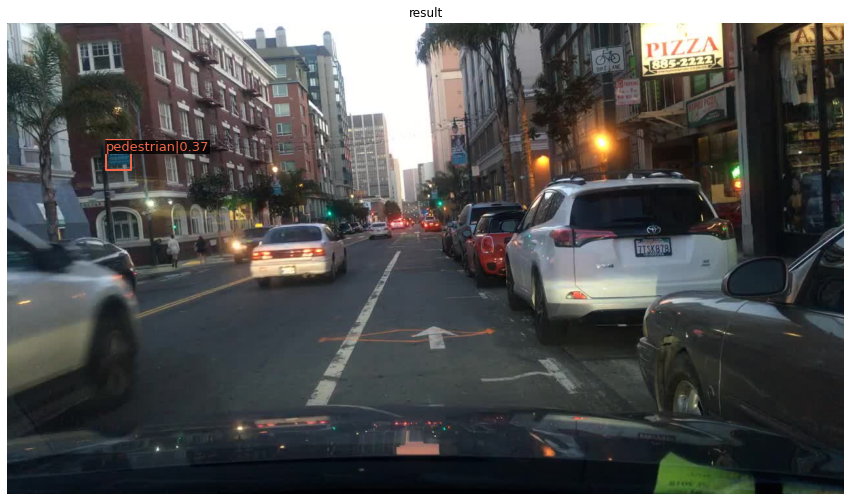

In [114]:
img = mmcv.imread('/content/bdd100k/images/100k/train/b11496d7-64b7b0e3.jpg')

model.cfg = cfg
model.eval()
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

/content/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/content/mmdetection/mmdet/apis/inference.py:205: UserWarning: "block" will be deprecated in v2.9.0,Please use "wait_time"
  warnings.warn('"block" will be deprecated in v2.9.0,'
/content/mmdetection/mmdet/core/visualization/image.py:76: UserWarning: "font_scale" will be deprecated in v2.9.0,Please use "font_size"
  warnings.warn('"font_scale" will be deprecated in v2.9.0,'


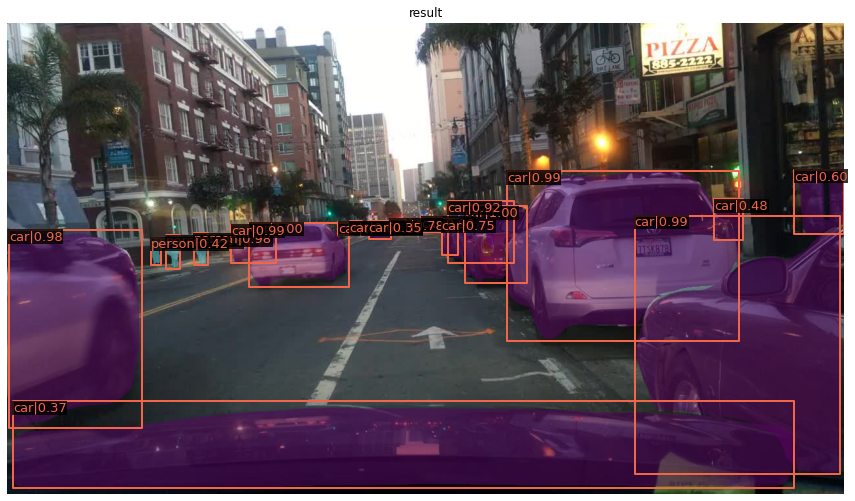

In [117]:
config = 'configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
checkpoint = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
# initialize the detector
model = init_detector(config, checkpoint)
img = mmcv.imread('/content/bdd100k/images/100k/train/b11496d7-64b7b0e3.jpg')
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

Feel free to test on your images:

In [ ]:
!wget <your image uri>

In [ ]:
!ls

/content/mmdetection/mmdet/apis/inference.py:186: UserWarning: "block" will be deprecated in v2.9.0,Please use "wait_time"
  warnings.warn('"block" will be deprecated in v2.9.0,'
/content/mmdetection/mmdet/core/visualization/image.py:76: UserWarning: "font_scale" will be deprecated in v2.9.0,Please use "font_size"
  warnings.warn('"font_scale" will be deprecated in v2.9.0,'


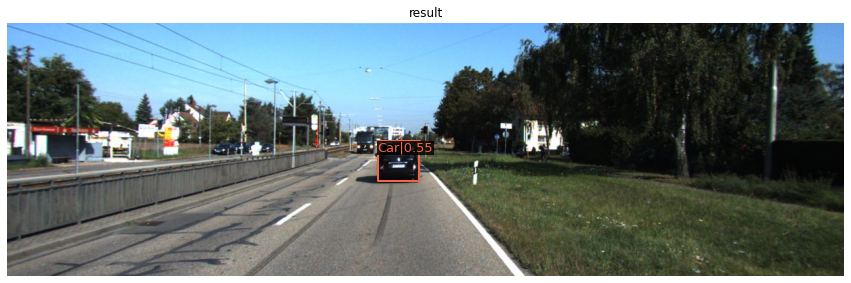

In [ ]:
img = mmcv.imread('your_image')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

## Useful links

- Andrej Karpathy (Tesla AI director) [keynote on multi-task learning](https://slideslive.com/38917690/multitask-learning-in-the-wilderness) (ENG)
- [CV practice 2019](https://www.youtube.com/watch?v=XSPYe4-y4HE) (RUS)
- [Habrahabr post: Classification & Representation](https://habr.com/ru/company/mipt/blog/458190/) (RUS)
- [Habrahabr post: Detection & Tracking](https://habr.com/ru/company/mipt/blog/450732/) (RUS)
